# Phase 4

## Imports and options

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from operator import itemgetter

from sklearn.model_selection import train_test_split
from sklearn import tree, metrics
from sklearn.tree import _tree


from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
import shap

import warnings
warnings.filterwarnings("ignore")


c:\Users\TK\Anaconda3\envs\tf\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\TK\Anaconda3\envs\tf\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swa

In [3]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
plt.ion()

In [6]:
sns.set()

In [7]:
#df = pd.read_csv('imputed.csv')

## Impute + 1 hot encode

In [8]:
initial_df = pd.read_csv('HMEQ_Loss.csv')

In [9]:
#break into groups for initial run
numerical_columns = []
categorical_columns = []
other_cols = []

dt=initial_df.dtypes

TARGET_F = 'TARGET_BAD_FLAG'
TARGET_A = 'TARGET_LOSS_AMT'

for i in dt.index:
    if i in ([TARGET_A,TARGET_F]):
        continue
    elif dt[i] in (["object"]) : 
        categorical_columns.append(i)
    elif dt[i] in (["float64"]) : 
        numerical_columns.append(i)
    elif dt[i] in (["int64"]) : 
        numerical_columns.append(i)
    else:
        other_cols.append(i)


In [10]:
#impute the categorical columns
#drop the originals
imputed_df = initial_df.copy()
for i in categorical_columns :
    if imputed_df[i].isna().sum() == 0: 
        continue
    NAME = "IMP_"+i
    imputed_df[NAME] = imputed_df[i]
    imputed_df[NAME] = imputed_df[NAME].fillna(imputed_df[NAME].mode()[0])
    print("variable",i," has this many missing", imputed_df[i].isna().sum())
    print("variable",NAME," has this many missing", imputed_df[NAME].isna().sum() ,'\n')
    g = imputed_df.groupby(NAME)
    print(g[NAME].count())
    print("\n\n")
    imputed_df = imputed_df.drop(i, axis=1)

variable REASON  has this many missing 252
variable IMP_REASON  has this many missing 0 

IMP_REASON
DebtCon    4180
HomeImp    1780
Name: IMP_REASON, dtype: int64



variable JOB  has this many missing 279
variable IMP_JOB  has this many missing 0 

IMP_JOB
Mgr         767
Office      948
Other      2667
ProfExe    1276
Sales       109
Self        193
Name: IMP_JOB, dtype: int64





In [11]:
#impute the numerical columns
#drop the originals
missing_flag_cols = []

for i in numerical_columns:
    if imputed_df[i].isna().sum() == 0:
        continue
    FLAG = 'M_' + i
    IMP = 'IMP_' + i
    imputed_df[FLAG] = imputed_df[i].isna() + 0
    missing_flag_cols.append(FLAG)
    imputed_df[IMP] = imputed_df[i]
    imputed_df.loc[imputed_df[IMP].isna(),IMP] = imputed_df[i].median()
    imputed_df = imputed_df.drop(i, axis=1)

In [12]:
#break into groups again with the dropped cols
imp_numerical_columns = []
imp_categorical_columns = []
imp_other_cols = []

dt=imputed_df.dtypes

TARGET_F = 'TARGET_BAD_FLAG'
TARGET_A = 'TARGET_LOSS_AMT'

for i in dt.index:
    if i in ([TARGET_A,TARGET_F]):
        continue
    elif dt[i] in (missing_flag_cols):
        imp_other_cols.append(i)
    elif dt[i] in (["object"]) : 
        imp_categorical_columns.append(i)
    elif dt[i] in (["float64"]) : 
        imp_numerical_columns.append(i)
    elif dt[i] in (["int64"]) : 
        imp_numerical_columns.append(i)
    else:
        imp_other_cols.append(i)

In [13]:
#now one hot encode the categorical columns
for i in imp_categorical_columns:
    prefix_name = 'z_' + i
    y = pd.get_dummies(imputed_df[i],prefix=prefix_name,drop_first=True)
    imputed_df = pd.concat([imputed_df,y],axis=1)
    imputed_df = imputed_df.drop(i,axis=1)


## Remove the outliers from the dataset


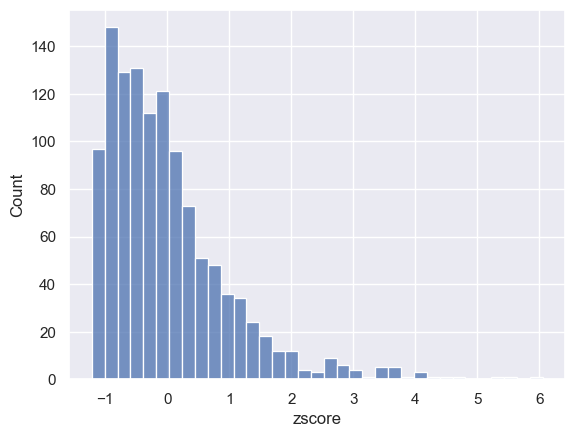

In [14]:
# from the imputed DF, let's keep only things within 3 standard deviations
# we'll use the scipy stats package to get the zscore
outlier_vis = imputed_df.copy()
outlier_vis['zscore'] = stats.zscore(outlier_vis[TARGET_A],nan_policy='omit')

# histogram of zscore
plot1 = sns.histplot(x=outlier_vis['zscore'], data=outlier_vis)
zfig = plot1.get_figure()
zfig.savefig('zscore_hist.png', bbox_inches='tight')
# get the absolute value of the zscore so we don't have to do > & < to get both upper and lower
# then save that as another df to use later on
# super important here is the or statement in filtering the df
# if you don't use the or part, you end up dropping all the nondefaults
imputed_no_outlier = imputed_df[(np.abs(stats.zscore(imputed_df[TARGET_A],nan_policy='omit')) < 3)\
                                 | ~imputed_df[TARGET_F].isna()].copy()

## Split the Data Into Test & Train

In [15]:
# drop the targets
# keep the predictors
# drop the missing flags as well
# uncomment to use no outlier
X = imputed_no_outlier.copy()
#X = imputed_df.copy()
X = X.drop(TARGET_F,axis=1)
X = X.drop(TARGET_A,axis=1)

for column in imputed_no_outlier.columns.values:
    if "M_" in column:
        X.drop(column,axis=1,inplace=True)

# the target we're predicting
Y = imputed_no_outlier[[TARGET_F,TARGET_A]]

# keep 80% for training
# keep 20% for testing
# use random_state=1 if you need the results to be the same (this sets our seed)
# X_train and Y_train should match up on the index
# X_test and Y_test should match up on the index
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, \
                                                    train_size=0.8, \
                                                    test_size=.2) #random_state=1

print("Training = ", X_train.shape)
print("Testing = ", X_test.shape)

Training =  (4768, 16)
Testing =  (1192, 16)


## Important Stuff

### Tree Stuff

In [16]:
def getEnsembleTreeVars(ENSTREE, varNames) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average(ENSTREE.feature_importances_) :
            v = int(imp_val / np.max(ENSTREE.feature_importances_) * 100)
            theList.append((varNames[i], v))
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

In [17]:
class AmountModel:
    # on creation
    def __init__(self, name, x_train, x_test, y_train, y_test,depth=5,random_state=511,estimators=100):
        self.name = name
        self.depth = depth
        self.r_state = random_state
        self.n_estimators = estimators
        self.features = list(x_train.columns.values)
        # get no null index
        amount_train_index = ~y_train[TARGET_A].isna()
        amount_test_index = ~y_test[TARGET_A].isna()

        # init amount variables
        self.X_Train = x_train[amount_train_index]
        self.Y_Train = y_train[amount_train_index]
        self.Y_Train = self.Y_Train[TARGET_A]
        self.X_Test = x_test[amount_test_index]
        self.Y_Test = y_test[amount_test_index]
        self.Y_Test = self.Y_Test[TARGET_A]
        print("After initailization, do a .setFlavor(pick a model), then a .fit(), then a .getAccuracy()")

    def setFlavor(self,flavor):
        if flavor == 'Tree':
            self.model = tree.DecisionTreeRegressor(max_depth=self.depth,random_state=self.r_state)
            self.flavor = flavor
        elif flavor == 'Random Forest':
            self.model = RandomForestRegressor(n_estimators = self.n_estimators, max_depth=self.depth,\
                                                random_state=self.r_state)
            self.flavor = flavor
        elif flavor == 'Gradient Boost':
            self.model = GradientBoostingRegressor(n_estimators = self.n_estimators, max_depth=self.depth,\
                                                random_state=self.r_state)
            self.flavor = flavor
        else:
            print('ERROR, please input Tree, Random Forest, Gradient Boost, or  Regression')

    def fit(self):
        self.model = self.model.fit(self.X_Train,self.Y_Train)
        self.Y_Pred_Train = self.model.predict(self.X_Train)
        self.Y_Pred_Test = self.model.predict(self.X_Test)

    def getVars(self):
        if self.flavor == 'Tree':
            self.important_variables = getTreeVars(self.model,self.features)
            #return self.important_variables
        elif self.flavor == 'Gradient Boost' or self.flavor == 'Random Forest':
            holder = getEnsembleTreeVars(self.model,self.features)
            self.important_variables = []
            for i in holder:
                smallhold = i[0]
                self.important_variables.append(smallhold)
            self.import_variables_matrix = holder
            #return self.important_variables
        else: 
            print('error')
            
    def getAccuracy(self):
        self.RMSE_train = math.sqrt(metrics.mean_squared_error(self.Y_Train,self.Y_Pred_Train))
        self.RMSE_test = math.sqrt(metrics.mean_squared_error(self.Y_Test,self.Y_Pred_Test))
        #print(f"{self.name} RMSE Train: ", self.RMSE_train)
        #print(f"{self.name} RMSE Test: ", self.RMSE_test)

class FlagModel:
    # on creation
    def __init__(self, name, x_train, x_test, y_train, y_test,depth=5,random_state=511,estimators=100):
        self.name = name
        self.depth = depth
        self.r_state = random_state
        self.n_estimators = estimators
        self.features = list(x_train.columns.values)
        
        # init flag variables
        self.X_Train = x_train
        self.Y_Train = y_train[TARGET_F]
        self.X_Test = x_test
        self.Y_Test = y_test[TARGET_F]
        print("After initailization, do a .setFlavor(pick a model), then a .fit(), then a .getAccuracy() and a .makeROCplot()")

    def setFlavor(self,flavor):
        if flavor == 'Tree':
            self.model = tree.DecisionTreeClassifier(max_depth=self.depth,random_state=self.r_state)
            self.flavor = flavor
        elif flavor == 'Random Forest':
            self.model = RandomForestClassifier(n_estimators = self.n_estimators, max_depth=self.depth,\
                                                random_state=self.r_state)
            self.flavor = flavor
        elif flavor == 'Gradient Boost':
            self.model = GradientBoostingClassifier(n_estimators = self.n_estimators, max_depth=self.depth,\
                                                random_state=self.r_state)
            self.flavor = flavor
        else:
            print('ERROR, please input Tree, Random Forest, or Gradient Boost')


    def fit(self):
        self.model = self.model.fit(self.X_Train,self.Y_Train)
        self.Y_Pred_Train = self.model.predict(self.X_Train)
        self.Y_Pred_Test = self.model.predict(self.X_Test)

    def getVars(self):
        if self.flavor == 'Tree':
            self.important_variables = getTreeVars(self.model,self.features)
            return self.important_variables
        elif self.flavor == 'Gradient Boost' or self.flavor == 'Random Forest':
            holder = getEnsembleTreeVars(self.model,self.features)
            self.important_variables = []
            for i in holder:
                smallhold = i[0]
                self.important_variables.append(smallhold)
            self.import_variables_matrix = holder
            return self.important_variables
        else: 
            print('error')
    

    def getAccuracy(self):
        self.train_acc = metrics.accuracy_score(self.Y_Train, self.Y_Pred_Train)
        self.test_acc = metrics.accuracy_score(self.Y_Test, self.Y_Pred_Test)
        #print("Accuracy Train: ", self.train_acc)
        #print("Accuracy Test: ", self.test_acc)

    def makeROCplot(self,filename):
        self.train_probs = self.model.predict_proba(self.X_Train)
        self.test_probs = self.model.predict_proba(self.X_Test)
        self.train_probs = self.train_probs[:,1]
        self.test_probs = self.test_probs[:,1]
        self.fpr_train, self.tpr_train, self.train_threshold = metrics.roc_curve(self.Y_Train, self.train_probs)
        self.fpr_test, self.tpr_test, self.test_threshold = metrics.roc_curve(self.Y_Test, self.test_probs)
        self.roc_auc_train = metrics.auc(self.fpr_train, self.tpr_train)
        self.roc_auc_test = metrics.auc(self.fpr_test, self.tpr_test)
        self.roc_plot = plt.figure(figsize=(5,5))
        plt.title(self.name + " ROC Curve")
        plt.plot(self.fpr_train, self.tpr_train,'b',label = 'AUC Train = %0.2f' % self.roc_auc_train)
        plt.plot(self.fpr_test, self.tpr_test,'r',label = 'AUC Test = %0.2f' % self.roc_auc_test)
        plt.legend(loc = 'lower right')
        plt.plot([0,1],[0,1],'k--')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.savefig(filename+'.png', bbox_inches='tight')
        #plt.show()

    

        


    

### NN Stuff

In [18]:
def get_TF_ProbAccuracyScores( NAME, MODEL, X, Y ) :
    probs = MODEL.predict( X )
    pred_list = []
    for p in probs :
        pred_list.append( np.argmax( p ) )
    pred = np.array( pred_list )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

In [19]:
class TF_Model:
    def __init__(self,name,x_train, x_test, y_train, y_test):
        self.name = name
        self.features = list(x_train.columns.values)
        self.X_Train = x_train
        self.Y_Train = y_train
        self.X_Test = x_test
        self.Y_Test = y_test

        self.scaler = MinMaxScaler()
        self.shapesize = self.X_Train.shape[1]
        self.units = int(2 * self.X_Train.shape[1] / 3)

    def chooseType(self, modeltype):
        
        if modeltype == 'Amount' or modeltype == 'amount':
            self.lossmetric = tf.keras.losses.MeanSquaredError()
            amount_train_index = ~self.Y_Train[TARGET_A].isna()
            amount_test_index = ~self.Y_Test[TARGET_A].isna()
            self.scaler = self.scaler.fit(self.X_Train)

            # train set
            self.X_Train = self.X_Train[amount_train_index]
            self.X_Train = self.scaler.transform(self.X_Train)
            self.X_Train = pd.DataFrame(self.X_Train,columns=list(self.features))
            self.Y_Train = self.Y_Train[amount_train_index]
            self.Y_Train = self.Y_Train[TARGET_A]

            # test set
            self.X_Test = self.X_Test[amount_test_index]
            self.X_Test = self.scaler.transform(self.X_Test)
            self.X_Test = pd.DataFrame(self.X_Test,columns=list(self.features))
            self.Y_Test = self.Y_Test[amount_test_index]
            self.Y_Test = self.Y_Test[TARGET_A]
            self.modeltype = 'amount'
            print('amount')

        elif modeltype == 'Flag' or modeltype == 'flag':
            self.lossmetric = tf.keras.losses.SparseCategoricalCrossentropy()
            self.scaler = self.scaler.fit(self.X_Train)

            # train set
            self.X_Train = self.scaler.transform(self.X_Train)
            self.X_Train = pd.DataFrame(self.X_Train,columns=list(self.features))
            self.Y_Train = self.Y_Train[TARGET_F]

            # test set
            self.X_Test = self.scaler.transform(self.X_Test)
            self.X_Test = pd.DataFrame(self.X_Test,columns=list(self.features))
            self.Y_Test = self.Y_Test[TARGET_F]
            self.modeltype = 'flag'
            print('flag')

        else:
            print('error')
    

    def getAccuracy(self):
        if self.modeltype == 'amount':
            self.Y_Pred_Train = self.model.predict(self.X_Train)
            self.training_acc_score = math.sqrt(metrics.mean_squared_error(self.Y_Train,self.Y_Pred_Train))

            self.Y_Pred_Test = self.model.predict(self.X_Test)
            self.test_acc_score = math.sqrt(metrics.mean_squared_error(self.Y_Test,self.Y_Pred_Test))
        
        elif self.modeltype == 'flag':
            probs = self.model.predict(self.X_Train)
            pred_list = []
            for p in probs :
                pred_list.append( np.argmax( p ) )
            pred = np.array( pred_list )
            self.training_acc_score = metrics.accuracy_score(self.Y_Train, pred)
            p1 = probs[:,1]
            self.train_fpr,  self.train_tpr,  self.train_threshold = metrics.roc_curve(self.Y_Train, p1)
            self.train_auc = metrics.auc(self.train_fpr,  self.train_tpr)

            probs = self.model.predict(self.X_Test)
            pred_list = []
            for p in probs :
                pred_list.append( np.argmax( p ) )
            pred = np.array( pred_list )
            self.test_acc_score = metrics.accuracy_score(self.Y_Test, pred)
            p1 = probs[:,1]
            self.test_fpr,  self.test_tpr,  self.test_threshold = metrics.roc_curve(self.Y_Test, p1)
            self.test_auc = metrics.auc(self.test_fpr,  self.test_tpr)
    
    def makeROCplot(self,filename):
        """self.train_probs = self.model.predict_proba(self.X_Train)
        self.test_probs = self.model.predict_proba(self.X_Test)
        self.train_probs = self.train_probs[:,1]
        self.test_probs = self.test_probs[:,1]
        self.fpr_train, self.tpr_train, self.train_threshold = metrics.roc_curve(self.Y_Train, self.train_probs)
        self.fpr_test, self.tpr_test, self.test_threshold = metrics.roc_curve(self.Y_Test, self.test_probs)
        self.roc_auc_train = metrics.auc(self.fpr_train, self.tpr_train)
        self.roc_auc_test = metrics.auc(self.fpr_test, self.tpr_test)"""
        self.roc_plot = plt.figure(figsize=(5,5))
        plt.title(self.name + " ROC Curve")
        plt.plot(self.train_fpr, self.train_tpr,'b',label = 'AUC Train = %0.2f' % self.train_auc)
        plt.plot(self.test_fpr, self.test_tpr,'r',label = 'AUC Test = %0.2f' % self.test_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0,1],[0,1],'k--')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.savefig(filename+'.png', bbox_inches='tight')
        plt.show()


## Adam 2 Layer w/ Drop

2 Layers Used
Layer 1 = relu
Layer 2 = relu

Includes drop layer with0.2

Output Layer = softmax for the flag, linear for the amount

We boost the nodes for the amount model to increase the accuracy (reduce the RMSE). Initial use of shape[1] * 2 results in an RMSE of 9K. Adjusting to * 10 halved the RMSE to around 4.4k.

### Flag

flag
38/38 [==============================] - 0s 649us/step
training accuracy = 0.8896812080536913
testing accuracy = 0.8800335570469798


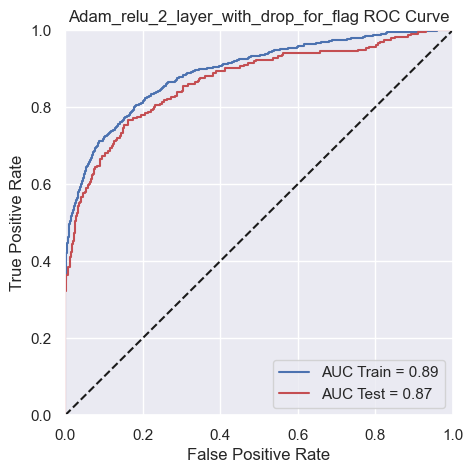

In [20]:
# init our class
adam_2_flag = TF_Model('Adam_relu_2_layer_with_drop_for_flag',X_train, X_test, Y_train, Y_test)

# choose our type
adam_2_flag.chooseType('flag')

# build our layers
layer_01 = tf.keras.layers.Dense(units = adam_2_flag.X_Train.shape[1] * 2, 
                                 activation = tf.keras.activations.relu, 
                                 input_dim= adam_2_flag.X_Train.shape[1])

layer_drop = tf.keras.layers.Dropout(0.2)

layer_02 = tf.keras.layers.Dense(units = adam_2_flag.X_Train.shape[1] * 2, 
                                 activation = tf.keras.activations.relu)

layer_output = tf.keras.layers.Dense(units = 2, 
                                     activation=tf.keras.activations.softmax)

# init our model
adam_2_flag.model = tf.keras.Sequential()

# add our layers to the model
adam_2_flag.model.add(layer_01)
adam_2_flag.model.add(layer_drop)
adam_2_flag.model.add(layer_02)
adam_2_flag.model.add(layer_output)
adam_2_flag.model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy())
adam_2_flag.model.fit(adam_2_flag.X_Train, adam_2_flag.Y_Train, epochs = 100, verbose=False)

# get the accuracy scores and print them off
adam_2_flag.getAccuracy()

print(f'training accuracy = {adam_2_flag.training_acc_score}')
print(f'testing accuracy = {adam_2_flag.test_acc_score}')

# make the ROC plot and save to file
adam_2_flag.makeROCplot(adam_2_flag.name)

### Amount

In [21]:
# init our class
adam_2_amount = TF_Model('Adam_relu_2_layer_with_drop_for_amount',X_train, X_test, Y_train, Y_test)

# choose our type
adam_2_amount.chooseType('amount')

# build our layers
layer_01 = tf.keras.layers.Dense(units = adam_2_amount.X_Train.shape[1] * 30, 
                                 activation = tf.keras.activations.relu, 
                                 input_dim= adam_2_amount.X_Train.shape[1])

layer_drop = tf.keras.layers.Dropout(0.2)

layer_02 = tf.keras.layers.Dense(units = (adam_2_amount.X_Train.shape[1] * 30), 
                                 activation = tf.keras.activations.relu)

layer_output = tf.keras.layers.Dense(units = 1, 
                                     activation=tf.keras.activations.linear)

# init our model
adam_2_amount.model = tf.keras.Sequential()

# add our layers to the model
adam_2_amount.model.add(layer_01)
adam_2_amount.model.add(layer_drop)
adam_2_amount.model.add(layer_02)
adam_2_amount.model.add(layer_output)
adam_2_amount.model.compile(loss = tf.keras.losses.MeanSquaredError())
adam_2_amount.model.fit(adam_2_amount.X_Train, adam_2_amount.Y_Train, epochs = 100, verbose=2)

# get the accuracy scores and print them off
adam_2_amount.getAccuracy()

print(f'training RMSE = {adam_2_amount.training_acc_score}')
print(f'testing RMSE = {adam_2_amount.test_acc_score}')

# make the ROC plot and save to file
#adam_2_amount.makeROCplot(adam_2_amount.name)

amount
Epoch 1/100
30/30 - 0s - loss: 298997568.0000 - 415ms/epoch - 14ms/step
Epoch 2/100
30/30 - 0s - loss: 292492384.0000 - 80ms/epoch - 3ms/step
Epoch 3/100
30/30 - 0s - loss: 278691104.0000 - 82ms/epoch - 3ms/step
Epoch 4/100
30/30 - 0s - loss: 256968528.0000 - 80ms/epoch - 3ms/step
Epoch 5/100
30/30 - 0s - loss: 227830576.0000 - 82ms/epoch - 3ms/step
Epoch 6/100
30/30 - 0s - loss: 194125568.0000 - 78ms/epoch - 3ms/step
Epoch 7/100
30/30 - 0s - loss: 160973776.0000 - 79ms/epoch - 3ms/step
Epoch 8/100
30/30 - 0s - loss: 131559688.0000 - 79ms/epoch - 3ms/step
Epoch 9/100
30/30 - 0s - loss: 112883376.0000 - 80ms/epoch - 3ms/step
Epoch 10/100
30/30 - 0s - loss: 104253424.0000 - 79ms/epoch - 3ms/step
Epoch 11/100
30/30 - 0s - loss: 100416584.0000 - 80ms/epoch - 3ms/step
Epoch 12/100
30/30 - 0s - loss: 97029368.0000 - 81ms/epoch - 3ms/step
Epoch 13/100
30/30 - 0s - loss: 93877824.0000 - 80ms/epoch - 3ms/step
Epoch 14/100
30/30 - 0s - loss: 90346800.0000 - 80ms/epoch - 3ms/step
Epoch 15/

## Adam 2 Layer w/ Drop featuring Sigmoid

2 Layers Used
Layer 1 = sigmoid
Layer 2 = relu

Includes drop layer with 0.2

Output Layer = softmax for the flag, linear for the amount

We boost the nodes for the amount model to increase the accuracy (reduce the RMSE). Initial use of shape[1] * 2 results in an RMSE of 9K. Adjusting to * 10 halved the RMSE to around 4.4k.

### Flag

flag
38/38 [==============================] - 0s 649us/step
training accuracy = 0.8309563758389261
testing accuracy = 0.8431208053691275


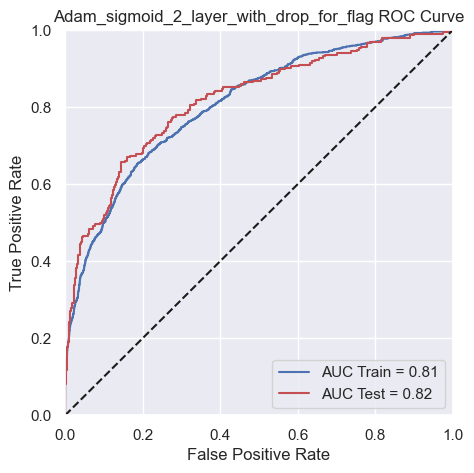

In [22]:
# init our class
adam_2_flag_sigmoid = TF_Model('Adam_sigmoid_2_layer_with_drop_for_flag',X_train, X_test, Y_train, Y_test)

# choose our type
adam_2_flag_sigmoid.chooseType('flag')

# build our layers
layer_01 = tf.keras.layers.Dense(units = adam_2_flag_sigmoid.X_Train.shape[1] * 2, 
                                 activation = tf.keras.activations.sigmoid, 
                                 input_dim= adam_2_flag_sigmoid.X_Train.shape[1])

layer_drop = tf.keras.layers.Dropout(0.2)

layer_02 = tf.keras.layers.Dense(units = adam_2_flag_sigmoid.X_Train.shape[1] * 2, 
                                 activation = tf.keras.activations.relu)

layer_output = tf.keras.layers.Dense(units = 2, 
                                     activation=tf.keras.activations.sigmoid)

# init our model
adam_2_flag_sigmoid.model = tf.keras.Sequential()

# add our layers to the model
adam_2_flag_sigmoid.model.add(layer_01)
adam_2_flag_sigmoid.model.add(layer_drop)
adam_2_flag_sigmoid.model.add(layer_02)
adam_2_flag_sigmoid.model.add(layer_output)
adam_2_flag_sigmoid.model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy())
adam_2_flag_sigmoid.model.fit(adam_2_flag_sigmoid.X_Train, adam_2_flag_sigmoid.Y_Train, epochs = 100, verbose=False)

# get the accuracy scores and print them off
adam_2_flag_sigmoid.getAccuracy()

print(f'training accuracy = {adam_2_flag_sigmoid.training_acc_score}')
print(f'testing accuracy = {adam_2_flag_sigmoid.test_acc_score}')

# make the ROC plot and save to file
adam_2_flag_sigmoid.makeROCplot(adam_2_flag_sigmoid.name)

### Amount

In [23]:
# init our class
adam_2_amount_sigmoid = TF_Model('Adam_sigmoid_2_layer_with_drop_for_amount',X_train, X_test, Y_train, Y_test)

# choose our type
adam_2_amount_sigmoid.chooseType('amount')

# build our layers
layer_01 = tf.keras.layers.Dense(units = adam_2_amount_sigmoid.X_Train.shape[1] * 30, 
                                 activation = tf.keras.activations.sigmoid, 
                                 input_dim= adam_2_amount_sigmoid.X_Train.shape[1])

layer_drop = tf.keras.layers.Dropout(0.2)

layer_02 = tf.keras.layers.Dense(units = (adam_2_amount_sigmoid.X_Train.shape[1] * 30), 
                                 activation = tf.keras.activations.relu)

layer_output = tf.keras.layers.Dense(units = 1, 
                                     activation=tf.keras.activations.linear)

# init our model
adam_2_amount_sigmoid.model = tf.keras.Sequential()

# add our layers to the model
adam_2_amount_sigmoid.model.add(layer_01)
adam_2_amount_sigmoid.model.add(layer_drop)
adam_2_amount_sigmoid.model.add(layer_02)
adam_2_amount_sigmoid.model.add(layer_output)
adam_2_amount_sigmoid.model.compile(loss = tf.keras.losses.MeanSquaredError())
adam_2_amount_sigmoid.model.fit(adam_2_amount_sigmoid.X_Train, adam_2_amount_sigmoid.Y_Train, epochs = 100, verbose=0)

# get the accuracy scores and print them off
adam_2_amount_sigmoid.getAccuracy()

print(f'training RMSE = {adam_2_amount_sigmoid.training_acc_score}')
print(f'testing RMSE = {adam_2_amount_sigmoid.test_acc_score}')

# make the ROC plot and save to file
#adam_2_amount_sigmoid.makeROCplot(adam_2_amount_sigmoid.name)

amount
8/8 [==============================] - 0s 1000us/step
training RMSE = 7427.239538516641
testing RMSE = 7355.6162019653


## Adam 1 Layer NO Drop

1 Layers Used
Layer 1 = relu

Output Layer = softmax for the flag, linear for the amount

Overall accuracy is pretty similar for 2 layer vs 1 layer in classification.

With 2 layers + dropout:

training accuracy = 0.8901006711409396
testing accuracy = 0.8691275167785235

With 1 layer no drop out:

training accuracy = 0.8705956375838926
testing accuracy = 0.8540268456375839

Huge performance drop off however for amount modeling.

With nodes = shape[1] (16) * 2 = 32 

training RMSE = 16245.351858629783
testing RMSE = 17798.31076669347

With shape[1] (16) * 30 = 480

training RMSE = 10725.717170881262
testing RMSE = 12092.87050647649


### Flag

flag
38/38 [==============================] - 0s 622us/step
training accuracy = 0.8657718120805369
testing accuracy = 0.860738255033557


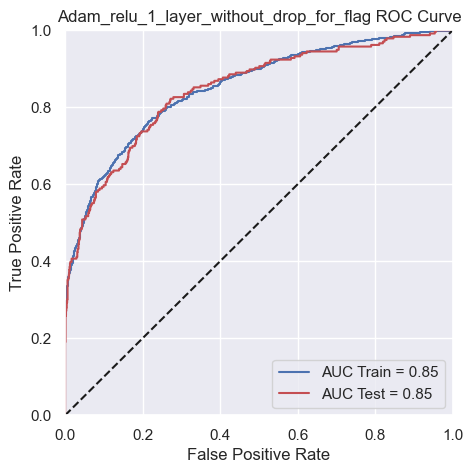

In [24]:
# init our class
adam_1_flag = TF_Model('Adam_relu_1_layer_without_drop_for_flag',X_train, X_test, Y_train, Y_test)

# choose our type
adam_1_flag.chooseType('flag')

# build our layers
layer_01 = tf.keras.layers.Dense(units = adam_1_flag.X_Train.shape[1] * 2, 
                                 activation = tf.keras.activations.relu, 
                                 input_dim= adam_1_flag.X_Train.shape[1])


layer_output = tf.keras.layers.Dense(units = 2, 
                                     activation=tf.keras.activations.softmax)

# init our model
adam_1_flag.model = tf.keras.Sequential()

# add our layers to the model
adam_1_flag.model.add(layer_01)
adam_1_flag.model.add(layer_output)
adam_1_flag.model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy())
adam_1_flag.model.fit(adam_1_flag.X_Train, adam_1_flag.Y_Train, epochs = 100, verbose=False)

# get the accuracy scores and print them off
adam_1_flag.getAccuracy()

print(f'training accuracy = {adam_1_flag.training_acc_score}')
print(f'testing accuracy = {adam_1_flag.test_acc_score}')

# make the ROC plot and save to file
adam_1_flag.makeROCplot(adam_1_flag.name)

### Amount

In [25]:
# init our class
adam_1_amount = TF_Model('Adam_relu_1_layer_with_drop_for_amount',X_train, X_test, Y_train, Y_test)

# choose our type
adam_1_amount.chooseType('amount')

# build our layers
layer_01 = tf.keras.layers.Dense(units = adam_1_amount.X_Train.shape[1] * 30, 
                                 activation = tf.keras.activations.relu, 
                                 input_dim= adam_1_amount.X_Train.shape[1])

layer_output = tf.keras.layers.Dense(units = 1, 
                                     activation=tf.keras.activations.linear)

# init our model
adam_1_amount.model = tf.keras.Sequential()

# add our layers to the model
adam_1_amount.model.add(layer_01)
adam_1_amount.model.add(layer_output)
adam_1_amount.model.compile(loss = tf.keras.losses.MeanSquaredError())
adam_1_amount.model.fit(adam_1_amount.X_Train, adam_1_amount.Y_Train, epochs = 100, verbose=2)

# get the accuracy scores and print them off
adam_1_amount.getAccuracy()

print(f'training RMSE = {adam_1_amount.training_acc_score}')
print(f'testing RMSE = {adam_1_amount.test_acc_score}')

# make the ROC plot and save to file
#adam_1_amount.makeROCplot(adam_1_amount.name)

amount
Epoch 1/100
30/30 - 0s - loss: 300127328.0000 - 264ms/epoch - 9ms/step
Epoch 2/100
30/30 - 0s - loss: 299991808.0000 - 23ms/epoch - 767us/step
Epoch 3/100
30/30 - 0s - loss: 299797664.0000 - 23ms/epoch - 767us/step
Epoch 4/100
30/30 - 0s - loss: 299547040.0000 - 22ms/epoch - 733us/step
Epoch 5/100
30/30 - 0s - loss: 299236384.0000 - 21ms/epoch - 700us/step
Epoch 6/100
30/30 - 0s - loss: 298865792.0000 - 21ms/epoch - 700us/step
Epoch 7/100
30/30 - 0s - loss: 298432864.0000 - 22ms/epoch - 733us/step
Epoch 8/100
30/30 - 0s - loss: 297946560.0000 - 22ms/epoch - 733us/step
Epoch 9/100
30/30 - 0s - loss: 297404064.0000 - 21ms/epoch - 700us/step
Epoch 10/100
30/30 - 0s - loss: 296808096.0000 - 22ms/epoch - 733us/step
Epoch 11/100
30/30 - 0s - loss: 296157248.0000 - 21ms/epoch - 700us/step
Epoch 12/100
30/30 - 0s - loss: 295444800.0000 - 22ms/epoch - 733us/step
Epoch 13/100
30/30 - 0s - loss: 294679840.0000 - 22ms/epoch - 733us/step
Epoch 14/100
30/30 - 0s - loss: 293849312.0000 - 22ms/

## Adam 2 Layer w/ Tree + Drop

Flag

After initailization, do a .setFlavor(pick a model), then a .fit(), then a .getAccuracy() and a .makeROCplot()


['IMP_DEBTINC', 'IMP_DELINQ', 'IMP_DEROG', 'IMP_CLAGE']

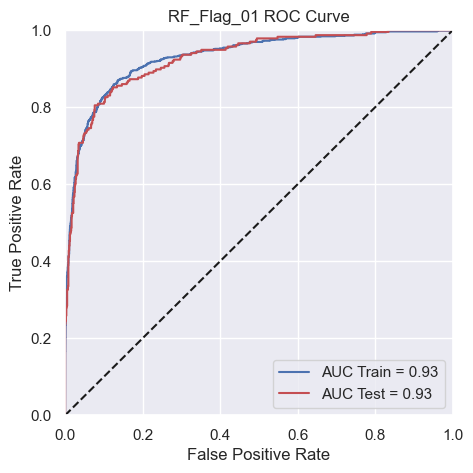

In [26]:
rf_flag_01 = FlagModel('RF_Flag_01',X_train, X_test, Y_train, Y_test)
rf_flag_01.setFlavor('Random Forest')
rf_flag_01.fit()
rf_flag_01.getAccuracy()
rf_flag_01.makeROCplot(rf_flag_01.name)
rf_flag_01.getVars()

flag
38/38 [==============================] - 0s 649us/step
training accuracy = 0.8403942953020134
testing accuracy = 0.8447986577181208


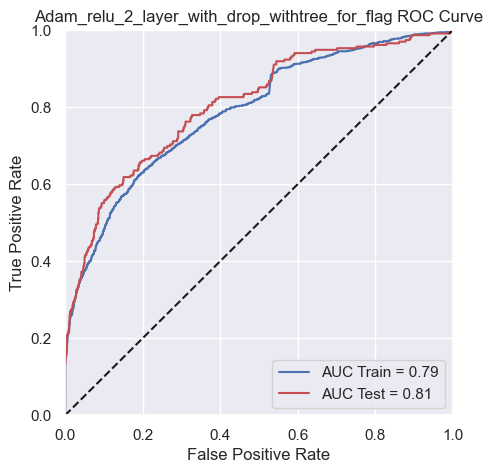

In [27]:
# init our class
adam_2_flag_withtree = TF_Model('Adam_relu_2_layer_with_drop_withtree_for_flag',
                                X_train[rf_flag_01.important_variables], 
                                X_test[rf_flag_01.important_variables], 
                                Y_train, 
                                Y_test)

# choose our type
adam_2_flag_withtree.chooseType('flag')

# build our layers
layer_01 = tf.keras.layers.Dense(units = adam_2_flag_withtree.X_Train.shape[1] * 2, 
                                 activation = tf.keras.activations.relu, 
                                 input_dim= adam_2_flag_withtree.X_Train.shape[1])

layer_drop = tf.keras.layers.Dropout(0.2)

layer_02 = tf.keras.layers.Dense(units = adam_2_flag_withtree.X_Train.shape[1] * 2, 
                                 activation = tf.keras.activations.relu)

layer_output = tf.keras.layers.Dense(units = 2, 
                                     activation=tf.keras.activations.softmax)

# init our model
adam_2_flag_withtree.model = tf.keras.Sequential()

# add our layers to the model
adam_2_flag_withtree.model.add(layer_01)
adam_2_flag_withtree.model.add(layer_drop)
adam_2_flag_withtree.model.add(layer_02)
adam_2_flag_withtree.model.add(layer_output)
adam_2_flag_withtree.model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy())
adam_2_flag_withtree.model.fit(adam_2_flag_withtree.X_Train, adam_2_flag_withtree.Y_Train, epochs = 100, verbose=False)

# get the accuracy scores and print them off
adam_2_flag_withtree.getAccuracy()

print(f'training accuracy = {adam_2_flag_withtree.training_acc_score}')
print(f'testing accuracy = {adam_2_flag_withtree.test_acc_score}')

# make the ROC plot and save to file
adam_2_flag_withtree.makeROCplot(adam_2_flag_withtree.name)

### Amount

In [28]:
rf_amount_01 = AmountModel('RF_Amount_01',X_train, X_test, Y_train, Y_test)
rf_amount_01.setFlavor('Random Forest')
rf_amount_01.fit()
rf_amount_01.getAccuracy()
rf_amount_01.getVars()

After initailization, do a .setFlavor(pick a model), then a .fit(), then a .getAccuracy()


In [29]:
rf_flag_01.important_variables

['IMP_DEBTINC', 'IMP_DELINQ', 'IMP_DEROG', 'IMP_CLAGE']

In [30]:
rf_flag_vars = []

[rf_flag_01.important_variables]

[['IMP_DEBTINC', 'IMP_DELINQ', 'IMP_DEROG', 'IMP_CLAGE']]

In [31]:
# init our class
adam_2_amount_withtree = TF_Model('Adam_relu_2_layer_with_drop_withtree_for_amount',
                                  X_train[rf_amount_01.important_variables], 
                                  X_test[rf_amount_01.important_variables], 
                                  Y_train, 
                                  Y_test)

# choose our type
adam_2_amount_withtree.chooseType('amount')

# build our layers
layer_01 = tf.keras.layers.Dense(units = adam_2_amount_withtree.X_Train.shape[1] * 30, 
                                 activation = tf.keras.activations.relu, 
                                 input_dim= adam_2_amount_withtree.X_Train.shape[1])

layer_drop = tf.keras.layers.Dropout(0.2)

layer_02 = tf.keras.layers.Dense(units = (adam_2_amount_withtree.X_Train.shape[1] * 30), 
                                 activation = tf.keras.activations.relu)

layer_output = tf.keras.layers.Dense(units = 1, 
                                     activation=tf.keras.activations.linear)

# init our model
adam_2_amount_withtree.model = tf.keras.Sequential()

# add our layers to the model
adam_2_amount_withtree.model.add(layer_01)
adam_2_amount_withtree.model.add(layer_drop)
adam_2_amount_withtree.model.add(layer_02)
adam_2_amount_withtree.model.add(layer_output)
adam_2_amount_withtree.model.compile(loss = tf.keras.losses.MeanSquaredError())
adam_2_amount_withtree.model.fit(adam_2_amount_withtree.X_Train, adam_2_amount_withtree.Y_Train, epochs = 100, verbose=2)

# get the accuracy scores and print them off
adam_2_amount_withtree.getAccuracy()

print(f'training RMSE = {adam_2_amount_withtree.training_acc_score}')
print(f'testing RMSE = {adam_2_amount_withtree.test_acc_score}')

# make the ROC plot and save to file
#adam_2_amount_withtree.makeROCplot(adam_2_amount_withtree.name)

amount
Epoch 1/100
30/30 - 0s - loss: 300164000.0000 - 354ms/epoch - 12ms/step
Epoch 2/100
30/30 - 0s - loss: 300119904.0000 - 25ms/epoch - 833us/step
Epoch 3/100
30/30 - 0s - loss: 300040704.0000 - 25ms/epoch - 833us/step
Epoch 4/100
30/30 - 0s - loss: 299914880.0000 - 24ms/epoch - 800us/step
Epoch 5/100
30/30 - 0s - loss: 299741504.0000 - 25ms/epoch - 833us/step
Epoch 6/100
30/30 - 0s - loss: 299503424.0000 - 24ms/epoch - 800us/step
Epoch 7/100
30/30 - 0s - loss: 299198528.0000 - 24ms/epoch - 800us/step
Epoch 8/100
30/30 - 0s - loss: 298824576.0000 - 23ms/epoch - 767us/step
Epoch 9/100
30/30 - 0s - loss: 298370080.0000 - 23ms/epoch - 767us/step
Epoch 10/100
30/30 - 0s - loss: 297820448.0000 - 25ms/epoch - 833us/step
Epoch 11/100
30/30 - 0s - loss: 297172256.0000 - 24ms/epoch - 800us/step
Epoch 12/100
30/30 - 0s - loss: 296424000.0000 - 24ms/epoch - 800us/step
Epoch 13/100
30/30 - 0s - loss: 295549888.0000 - 24ms/epoch - 800us/step
Epoch 14/100
30/30 - 0s - loss: 294596064.0000 - 25ms

## Summary

In [32]:
flag_models_list = [adam_2_flag,               
                adam_2_flag_sigmoid,
                adam_2_flag_withtree,
                adam_1_flag]

In [33]:
amount_models_list = [adam_2_amount,
                      adam_2_amount_sigmoid,
                      adam_2_amount_withtree,
                      adam_1_amount]

### ROC Curves

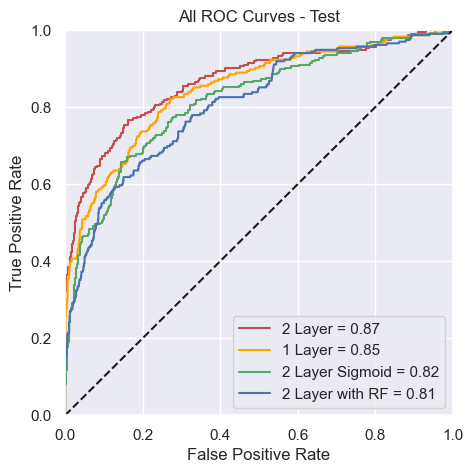

In [34]:
plt.figure(figsize=(5,5))
plt.title("All ROC Curves - Test")
plt.plot(adam_2_flag.test_fpr, adam_2_flag.test_tpr,'r',label = '2 Layer = %0.2f' % adam_2_flag.test_auc)
plt.plot(adam_1_flag.test_fpr, adam_1_flag.test_tpr,'orange',label = '1 Layer = %0.2f' % adam_1_flag.test_auc)
plt.plot(adam_2_flag_sigmoid.test_fpr, adam_2_flag_sigmoid.test_tpr,'g',label = '2 Layer Sigmoid = %0.2f' % adam_2_flag_sigmoid.test_auc)
plt.plot(adam_2_flag_withtree.test_fpr, adam_2_flag_withtree.test_tpr,'b',label = '2 Layer with RF = %0.2f' % adam_2_flag_withtree.test_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('All_ROC_Curves-Test.png', bbox_inches='tight')
plt.show()

### RMSE Table

In [35]:
holder = []
for thing in amount_models_list:
    smalldict = {}
    smalldict['name'] = thing.name
    smalldict['test_RMSE'] = thing.test_acc_score
    holder.append(smalldict)

rmse_df = pd.DataFrame(holder)
rmse_df.head()

,name,test_RMSE
0,Adam_relu_2_layer_with_drop_for_amount,4346.205541
1,Adam_sigmoid_2_layer_with_drop_for_amount,7355.616202
2,Adam_relu_2_layer_with_drop_withtree_for_amount,8823.641885
3,Adam_relu_1_layer_with_drop_for_amount,10979.925746


In [37]:
explainer = shap.KernelExplainer(adam_2_flag.model.predict,adam_2_flag.X_Train)

149/149 [==============================] - 0s 642us/step


Using 4768 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
